In [ ]:
!pip install keras

In [ ]:
!pip install visualkeras

In [ ]:
!pip install tensorflow_addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


A saída de streaming foi truncada nas últimas 5000 linhas.
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1469.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1420.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1482.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1425.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1478.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1414.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1476.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1443.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1467.png
/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal/Normal-1451.png
/content/drive/MyDriv

In [ ]:

import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow.keras.backend as K
import visualkeras

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import sklearn.metrics
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
base_dir= "/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database"
os.listdir(base_dir)

['Normal.metadata.xlsx',
 'README.md.txt',
 'Tuberculosis.metadata.xlsx',
 'Normal',
 'Tuberculosis']

In [ ]:
tuberculosis_data= "/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Tuberculosis"
print("Diretorio tuberculose:\n" ,os.listdir(tuberculosis_data)[:5])

normal_data= "/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal"
print("\nDiretorio normal :\n" ,os.listdir(normal_data)[:5])

Diretorio tuberculose:
 ['Tuberculosis-413.png', 'Tuberculosis-412.png', 'Tuberculosis-415.png', 'Tuberculosis-416.png', 'Tuberculosis-414.png']

Diretorio normal :
 ['Normal-3337.png', 'Normal-3353.png', 'Normal-3218.png', 'Normal-3339.png', 'Normal-3371.png']


In [ ]:
print("no. de imagens de tuberculose :" ,len(os.listdir(tuberculosis_data)))
print("\nno. de imagens normais :" ,len(os.listdir(normal_data)))

no. de imagens de tuberculose : 3500

no. de imagens normais : 3500


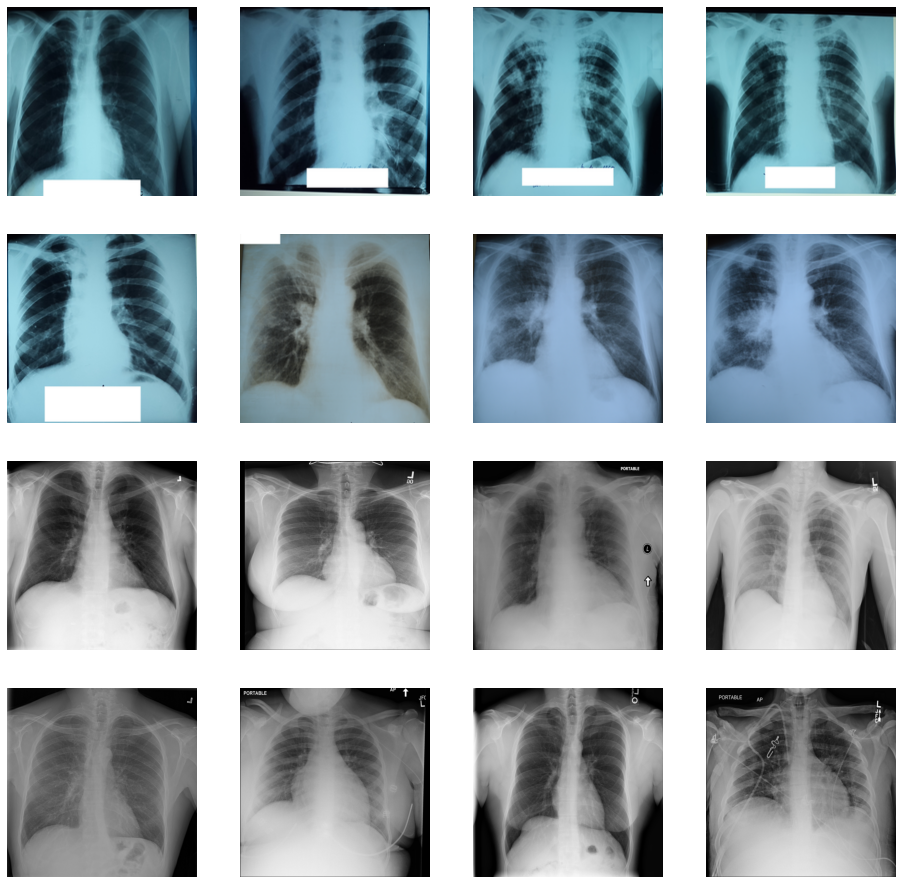

In [ ]:
nrows= 4
ncols= 4
pic_index= 0

fig= plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8

tuberculosis_img = [os.path.join(tuberculosis_data, image) for image in os.listdir(tuberculosis_data)[pic_index-8:pic_index]]
normal_img = [os.path.join(normal_data, image) for image in os.listdir(normal_data)[pic_index-8:pic_index]]

for i, image_path in enumerate(tuberculosis_img+normal_img):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 

    img = mpimg.imread(image_path)
    plt.imshow(img)

plt.show()

In [ ]:
image= imread("/content/drive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-200.png")
image.shape

(512, 512, 3)

In [ ]:
print("Dados de treino :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              subset= "training"
                                              )


print("\ndados de validação :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              shuffle= False,
                                              subset= "validation"
                                              )

Dados de treino :
Found 5600 images belonging to 2 classes.

dados de validação :
Found 1400 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [ ]:
res_model= ResNet50(input_shape= (300, 300,3), include_top= False, weights="imagenet")

last_output= res_model.layers[-1].output

last_output= Flatten()(last_output)

pretrained_model= Model(res_model.input, last_output)    

In [ ]:
pretrained_model.summary()

In [ ]:
x= Dense(units=128, activation="relu")(last_output)
x=Dropout(0.2)(x)

x= Dense(units=32, activation="relu")(x)
x=Dropout(0.2)(x)

x= Dense(units=1, activation="sigmoid")(x)

model= Model(pretrained_model.input, x)

model.summary()

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='acuracia'),
      tf.keras.metrics.Precision(name='precisão'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      #tfa.metrics.F1Score(num_classes=4)
      f1_score
]

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=METRICS)

In [ ]:
for layer in model.layers:
    layer.trainable= False

In [ ]:
history= model.fit(train_data,
                   validation_data= val_data,
                   epochs = 20,
                   verbose = 1,
                   callbacks=lr_scheduler
                  )

Epoch 1/20
280/280 [==============================] - 334s 1s/step - loss: 0.4586 - acuracia: 0.9043 - precisão: 0.9110 - recall: 0.8961 - auc: 0.9518 - f1_score: 0.9015 - val_loss: 1077.7206 - val_acuracia: 0.5000 - val_precisão: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_score: 0.5000 - lr: 0.0010
Epoch 2/20
280/280 [==============================] - 330s 1s/step - loss: 0.2220 - acuracia: 0.9491 - precisão: 0.9545 - recall: 0.9432 - auc: 0.9817 - f1_score: 0.9458 - val_loss: 51.0782 - val_acuracia: 0.5000 - val_precisão: 0.5000 - val_recall: 1.0000 - val_auc: 0.4993 - val_f1_score: 0.5000 - lr: 3.9811e-04
Epoch 3/20
280/280 [==============================] - 329s 1s/step - loss: 0.1321 - acuracia: 0.9643 - precisão: 0.9710 - recall: 0.9571 - auc: 0.9883 - f1_score: 0.9630 - val_loss: 30.6842 - val_acuracia: 0.5400 - val_precisão: 1.0000 - val_recall: 0.0800 - val_auc: 0.5464 - val_f1_score: 0.0603 - lr: 1.5849e-04
Epoch 4/20
280/280 [==============================] - 326

In [ ]:
history.history.keys()

dict_keys(['loss', 'acuracia', 'precisão', 'recall', 'auc', 'f1_score', 'val_loss', 'val_acuracia', 'val_precisão', 'val_recall', 'val_auc', 'val_f1_score', 'lr'])

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision, recall, val_recall,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" Metricas do modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Teste'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Folds')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Teste'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Folds')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Teste'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Folds')
    ax4.set_ylabel('Precisão')
    ax1.legend(['Treino', 'Teste'])

    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('Recall')
    ax5.set_xlabel('Folds')
    ax5.set_ylabel('Recall')
    ax1.legend(['Treino', 'Teste'])

    
    '''ax6.plot(range(1, len(f1) + 1), f1)
    ax6.plot(range(1, len(val_f1) + 1), val_f1)
    ax6.set_title('F1-score')
    ax6.set_xlabel('Folds')
    ax6.set_ylabel('F1 score')
    ax1.legend(['Treino', 'Teste'])'''


    plt.show()
    

Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
prediction= model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=2)
prediction= (prediction > 0.5)
prediction

In [ ]:
val_labels=val_data.classes
val_labels

In [ ]:
prediction.shape

In [ ]:
val_labels.shape

In [ ]:
cm= confusion_matrix(val_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(val_data.classes, prediction))
print(classification_report(val_data.classes, prediction))

In [ ]:
visualkeras.layered_view(model)